In [78]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [79]:
df = pd.read_csv('../data/row_data.csv')

In [80]:
# Sort data by date
df = df.sort_values(by='date')

# Drop 'date' column for now
df = df.drop(['date'], axis=1)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [81]:
from joblib import dump

# Assuming 'scaler' is your MinMaxScaler object
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [82]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        X.append(seq[:-1])
        y.append(seq[-1][df.columns.get_loc("大盤_收盤價")])
    return np.array(X), np.array(y)

In [94]:
len(scaled_data)

3924

In [83]:
seq_length = 3  # for example, use the last 10 days to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing (80-20 split for example)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [84]:
# Model Creation
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [85]:
# Model Training
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
49/49 [==============================] - 4s 18ms/step - loss: 0.0190 - val_loss: 0.0319
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 6.5163e-04 - val_loss: 6.1809e-04
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 4.1990e-04 - val_loss: 0.0012
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 2.6238e-04 - val_loss: 0.0024
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 1.6826e-04 - val_loss: 0.0029
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 1.2489e-04 - val_loss: 0.0036
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 1.0992e-04 - val_loss: 0.0035
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 1.0210e-04 - val_loss: 0.0039
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 9.7264e-05 -

In [86]:
# Predictions
predictions = model.predict(X_test)

25/25 [==============================] - 1s 2ms/step


In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [88]:
# For Regression
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.0040352102477442635
Mean Absolute Error: 0.05609542353406009


In [89]:
# For Classification (predicting up or down movements)
y_test_direction = np.where(np.diff(y_test) >= 0, 1, 0)
predictions_direction = np.where(np.diff(predictions[:, 0]) >= 0, 1, 0)

accuracy = accuracy_score(y_test_direction, predictions_direction)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 51.02%


In [90]:
predictions.shape

(785, 1)

In [91]:
df = pd.read_csv('../data/row_data.csv')

# Number of columns in the original dataset (excluding 'date')
num_columns = X_test.shape[2]

# Create a dummy array for predictions
dummy_array_predictions = np.zeros((predictions.shape[0], num_columns))
# Place the predictions in the correct column
target_index = list(df.columns).index('大盤_收盤價') - 1  # Adjust for 'date' column
dummy_array_predictions[:, target_index] = predictions.flatten()

# Denormalize the predictions
predictions_denorm = scaler.inverse_transform(dummy_array_predictions)[:, target_index]

# Create a dummy array for y_test
dummy_array_y_test = np.zeros((y_test.shape[0], num_columns))
# Place the y_test values in the correct column
dummy_array_y_test[:, target_index] = y_test.flatten()

# Denormalize y_test
y_test_denorm = scaler.inverse_transform(dummy_array_y_test)[:, target_index]


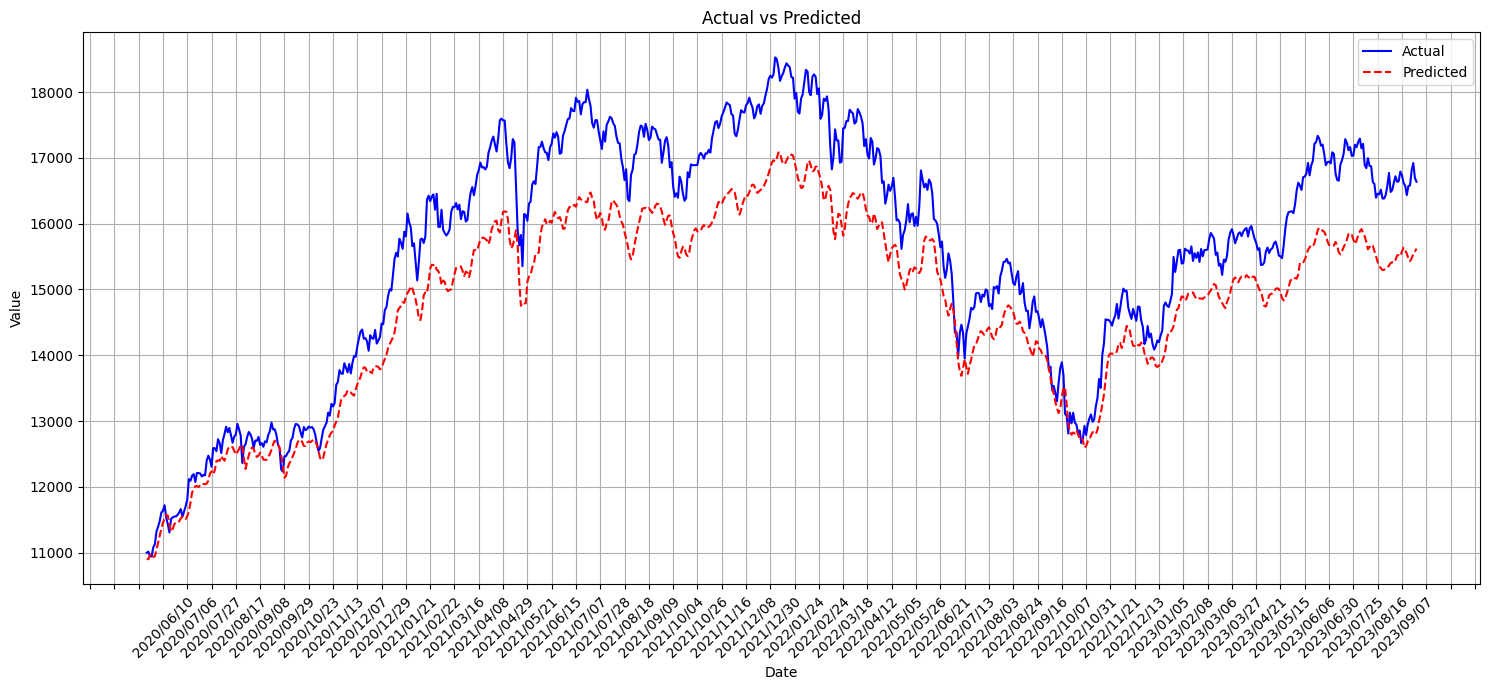

In [98]:
df = pd.read_csv('../data/row_data.csv')
dates = df['date'].values[-len(y_test):]

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(dates, y_test_denorm, label="Actual", color='blue')
plt.plot(dates, predictions_denorm, label="Predicted", color='red', linestyle='dashed')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.tight_layout()
plt.show()

In [93]:
model.save("LSTM_tomorrow.h5")

c:\Users\overf\anaconda3\envs\StockMarketIndexAI\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
